In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import torch
from fastai.vision.all import *
from fastai.distributed import *

import fastai
import sklearn.metrics as skm

import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 170)
pd.set_option('display.max_colwidth', None)

import numpy as np
from matplotlib import pyplot as plt
import openslide
from numpy import asarray
import cv2
import scipy.io as sio
import h5py



Bad key "text.kerning_factor" on line 4 in
/home/auri/anaconda3/envs/fastaiAP/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## Classification of TCGA CRC in MSS vs MSI


In [2]:
Path('TCGA').ls()

(#10) [Path('TCGA/SVS'),Path('TCGA/merged_TCGA_TUM_clini_table_v1.xlsx'),Path('TCGA/merged_TCGA_TUM_slide_table_v1.xlsx'),Path('TCGA/TCGA_MSI-H.csv'),Path('TCGA/TCGA_MSI-L.csv'),Path('TCGA/TCGA_MSS.csv'),Path('TCGA/MSI-H_project'),Path('TCGA/MSI-L_project'),Path('TCGA/MSS_project'),Path('TCGA/TILES')]

In [3]:
cx = pd.read_excel('TCGA/merged_TCGA_TUM_clini_table_v1.xlsx', index_col=0)

In [4]:
slide = pd.read_excel('TCGA/merged_TCGA_TUM_slide_table_v1.xlsx', index_col=0)

In [5]:
#blk-AAADECQEWVSD-TCGA-CM-4746-01Z-00-DX1.png' Case = TCGA-CM-4746 , Sample = 01Z, Portion = 00, Slide = 00-DX1
slide.head(1)

,slide_submitter_id,case_id,case_submitter_id,project_id,sample_id,sample_submitter_id,portion_id,portion_submitter_id,percent_tumor_nuclei,percent_normal_cells,percent_lymphocyte_infiltration,percent_neutrophil_infiltration,section_location,percent_necrosis,percent_stromal_cells,percent_tumor_cells
slide_id,,,,,,,,,,,,,,,,
da7fa2a0-e690-4593-a4e1-a3bba3c294ed,TCGA-DM-A1D7-01A-01-TSA,fac2c617-8149-45bb-b766-fbe13dc3c425,TCGA-DM-A1D7,TCGA-COAD,18364fcc-5f9c-4e3f-8a9e-56ed18ac893e,TCGA-DM-A1D7-01A,061b8a5e-463e-43c7-91e6-0d34a4d1effc,TCGA-DM-A1D7-01A-11,80,0.0,0.0,0.0,TOP,0.0,0.0,100.0


In [6]:
cx.head(1)

,submitter_id,project_id,gender,race,primary_diagnosis,tumor_stage,age_at_diagnosis,vital_status_TUM_clini,morphology,days_to_death,days_to_recurrence,tumor_grade,tissue_or_organ_of_origin,days_to_birth,progression_or_recurrence,site_of_resection_or_biopsy,days_to_last_follow_up,hasDied,cleanStage,Var1,bcr_patient_barcode,type,age_at_initial_pathologic_diagnosis,ajcc_pathologic_tumor_stage,clinical_stage,histological_type,histological_grade,initial_pathologic_dx_year,menopause_status,birth_days_to,vital_status_GIT_extraClini,tumor_status,last_contact_days_to,death_days_to,cause_of_death,new_tumor_event_type,new_tumor_event_site,new_tumor_event_site_other,new_tumor_event_dx_days_to,treatment_outcome_first_course,margin_status,residual_tumor,OS,OS_time,DSS,DSS_time,DFI,DFI_time,PFI,PFI_time,Redaction,TCGAParticipantBarcode,TCGAProjectCode,Organ,PathologicT,PathologicN,PathologicM,PathologicStage,Country,Gender2,AgeAtInitialPathologicDiagnosis,DaysToLastKnownAlive,VitalStatus,DetailedAnatomicSite,MSIStatus,Race3,GeographicRegion,LeukocyteFraction,CDKN2AMethylation,MLH1Methylation,BRCA1EpigeneticSilencing,RAD51C_epigenetic_silencing,TCellsCD8,NKCellsResting,MacrophagesM1,StemnessRNABased,StemnessDNAmethBased,ColorectalCMS,InterferonGammaResponse_C1Hallmark,WntBetaCateningSignaling_C1Hallmark,AnatomicRegion,LeftOrRightColon,Stage,HypermethylationCategory,GastricHistologicalClassification,...,MS_frac_stage1_CpGtoT,MS_frac_stage1_MSI_1,MS_frac_stage1_MSI_2,MS_frac_stage1_POLE_1,MS_frac_stage1_POLE_2,MS_frac_stage1_AAtoAC,MS_frac_stage1_residual,MS_stage2_BRCA,MS_stage2_APOBEC_1,MS_stage2_APOBEC_2,MS_stage2_AAtoAC,MS_stage2_CpGtoT,MS_frac_stage2_BRCA,MS_frac_stage2_APOBEC_1,MS_frac_stage2_APOBEC_2,MS_frac_stage2_AAtoAC,MS_frac_stage2_CpGtoT,n_silent,n_nonsilent,n_indel,SNVMutationDensity,IndelMutationDensity,MutationDensity,Hypermutated,arm_CN_1p,arm_CN_1q,arm_CN_2p,arm_CN_2q,arm_CN_3p,arm_CN_3q,arm_CN_4p,arm_CN_4q,arm_CN_5p,arm_CN_5q,arm_CN_6p,arm_CN_6q,arm_CN_7p,arm_CN_7q,arm_CN_8p,arm_CN_8q,arm_CN_9p,arm_CN_9q,arm_CN_10p,arm_CN_10q,arm_CN_11p,arm_CN_11q,arm_CN_12p,arm_CN_12q,arm_CN_13q,arm_CN_14q,arm_CN_15q,arm_CN_16p,arm_CN_16q,arm_CN_17p,arm_CN_17q,arm_CN_18p,arm_CN_18q,arm_CN_19p,arm_CN_19q,arm_CN_20p,arm_CN_20q,arm_CN_21q,arm_CN_22q,TCGA_Barcode,Cancer,Tota_Mutation_cnt,MSIscore,POLE,MLH1,MLH3,MGMT,MSH6,MSH3,MSH2,PMS1,PMS2,POLE_loc,MLH1_loc,MLH3_loc,MGMT_loc,MSH6_loc,MSH3_loc,MSH2_loc,PMS1_loc,PMS2_loc
case_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
a94e1279-a975-480a-93e9-7b1ff05cbcbf,TCGA-3L-AA1B,TCGA-COAD,female,black or african american,C18.0,stage i,22379,alive,8140/3,NaN,NaN,NaN,C18.0,-22379,NaN,C18.0,475.0,False,1.0,1954.0,TCGA-3L-AA1B,COAD,61.0,Stage I,[Not Applicable],Colon Adenocarcinoma,[Not Available],2013.0,[Not Available],-22379.0,Alive,TUMOR FREE,475.0,NaN,[Not Available],NaN,NaN,NaN,NaN,Complete Remission/Response,NaN,NaN,0.0,475.0,0.0,475.0,0.0,475.0,0.0,475.0,NaN,TCGA-3L-AA1B,COAD,COAD,T2,N0,M0,I,United_States,FEMALE,61.27,475.0,Alive,Cecum,MSS,BLACK OR AFRICAN AMERICAN,The_Americas,0.294204,1.0,0.0,0.0,0.0,0.067693,0.096849,0.013252,0.396243,0.15767,NaN,-0.469581,5.115828,Ascending_Colon,Right,I,CRC CIMP-L,NaN,...,0.462273,0.097712,0.0,0.065694,0.060483,0.0,0.313838,4.3087,2.144,4.1413,0.0,167.3836,0.024209,0.012046,0.023268,0.0,0.94048,48.0,103.0,2.0,4.19951,0.062065,4.261575,0.0,0.0,0.0,0.598,0.598,0.0,0.0,0.639,0.0,0.633,0.633,0.0,0.0,1.433,1.433,0.677,0.677,0.0,0.0,0.0,0.0,0.0,0.0,0.643,0.643,0.704,0.0,0.614,0.0,0.0,-0.661,0.058,-0.717,-0.717,0.0,0.0,1.46,1.46,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
slide.case_id.nunique(), cx.shape, slide.shape, cx.submitter_id.nunique()

(1687, (1076, 200), (4596, 16), 1076)

In [8]:
cx.loc[cx['submitter_id'] == 'TCGA-CM-4746']
#filter coad patients with MSI 

cx.loc[(cx['project_id'] == 'TCGA-COAD') & (cx['MSIStatus'] == 'MSI-H')].shape, cx.loc[(cx['project_id'] == 'TCGA-COAD') & (cx['MSIStatus'] == 'MSS')].shape

((61, 200), (218, 200))

In [9]:
cx.project_id.value_counts()

TCGA-COAD    461
TCGA-STAD    443
TCGA-READ    172
Name: project_id, dtype: int64

In [10]:
cx.MSIStatus.value_counts()

MSS      574
MSI-H    140
MSI-L    126
Name: MSIStatus, dtype: int64

In [11]:
','.join(cx.columns), ' '.join(slide.columns)

('submitter_id,project_id,gender,race,primary_diagnosis,tumor_stage,age_at_diagnosis,vital_status_TUM_clini,morphology,days_to_death,days_to_recurrence,tumor_grade,tissue_or_organ_of_origin,days_to_birth,progression_or_recurrence,site_of_resection_or_biopsy,days_to_last_follow_up,hasDied,cleanStage,Var1,bcr_patient_barcode,type,age_at_initial_pathologic_diagnosis,ajcc_pathologic_tumor_stage,clinical_stage,histological_type,histological_grade,initial_pathologic_dx_year,menopause_status,birth_days_to,vital_status_GIT_extraClini,tumor_status,last_contact_days_to,death_days_to,cause_of_death,new_tumor_event_type,new_tumor_event_site,new_tumor_event_site_other,new_tumor_event_dx_days_to,treatment_outcome_first_course,margin_status,residual_tumor,OS,OS_time,DSS,DSS_time,DFI,DFI_time,PFI,PFI_time,Redaction,TCGAParticipantBarcode,TCGAProjectCode,Organ,PathologicT,PathologicN,PathologicM,PathologicStage,Country,Gender2,AgeAtInitialPathologicDiagnosis,DaysToLastKnownAlive,VitalStatus,DetailedAna

In [12]:
path =  Path('TCGA/TILES') #downlaoded from zenodo, preprocessed by same authors as 

In [13]:
path.ls()

(#4) [Path('TCGA/TILES/MSIMUT'),Path('TCGA/TILES/MSS'),Path('TCGA/TILES/MSIMUT_VAL'),Path('TCGA/TILES/MSS_VAL')]

In [14]:
files = get_image_files(path)
len(files)

192312

In [15]:
files[0]

Path('TCGA/TILES/MSIMUT/blk-AAADECQEWVSD-TCGA-CM-4746-01Z-00-DX1.png')

In [16]:
def label_func(f): 
    cls = ['MSS', 'MSI']
    s = None
    try:
        
        s = 'MSI' if (('MSIMUT' in f.parent.parent.name) or ('MSIMUT' in f.parent.name)) else 'MSS'
        
    except :
        print(f)
    return s 
    

TCGA/TILES/MSIMUT/blk-DKRQCCLVEWWC-TCGA-QG-A5Z2-01Z-00-DX2.png


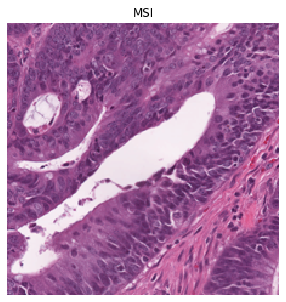

In [17]:
i =5798
print(files[i])
show_image(Image.open(files[i]), title= label_func(files[i]))

In [99]:
splitter = FuncSplitter(lambda o: 'VAL' in o.parent.parent.name)
#splitter = RandomSplitter(valid_pct = 0.5)

#splitter = FuncSplitter(lambda o: ('MSS' in o.parent.parent.name) or ('MSS' in o.parent.name))
#np.random.shuffle(files)
splitter(files)

((#93408) [1,4,8,10,13,17,19,20,21,22...],
 (#98904) [0,2,3,5,6,7,9,11,12,14...])

## calculate dataset stats (do not use imagenet_stats) 

In [100]:
calculate_stats = False
if calculate_stats:
    dls = spots_datablock.dataloaders(path, bs = 5000)
    print (dls[0].after_batch)
    bx=dls.one_batch()[0]
    print(bx.min(),bx.max(),bx.mean(dim=[0,2,3]),bx.std(dim=[0,2,3]))
    tissue_stats = (np.array(bx.mean(dim=[0,2,3]).cpu()),np.array(bx.std(dim=[0,2,3]).cpu()))
    print(tissue_stats)
else: 
    tissue_stats =  ([0.7700158 , 0.6154052 , 0.74566764],[0.19486967, 0.26420233, 0.19368471]) #TSR-CRC + NCT-CRC-HE
tissue_stats

([0.7700158, 0.6154052, 0.74566764], [0.19486967, 0.26420233, 0.19368471])

In [101]:
#dls = ImageDataLoaders.from_name_func(path, files, label_func)

In [102]:
item_tfms = Resize(224)
aug = aug_transforms(mult=1, flip_vert=True, max_rotate=90., min_zoom=0.9, max_zoom=1.1, 
                     max_lighting=0., max_warp=0., p_affine=0.75, p_lighting=0.,size = 224)
spots_datablock = DataBlock(blocks = (ImageBlock,CategoryBlock( vocab =  ['MSS', 'MSI'], sort = False)),
                  get_items = get_image_files,
                  splitter = splitter,
                  get_y = label_func,        
                  batch_tfms=[Normalize.from_stats(*tissue_stats),*aug]
                  )

In [103]:
dls = spots_datablock.dataloaders(path, bs=256 * 3,)


In [104]:
dls.vocab

['MSS', 'MSI']

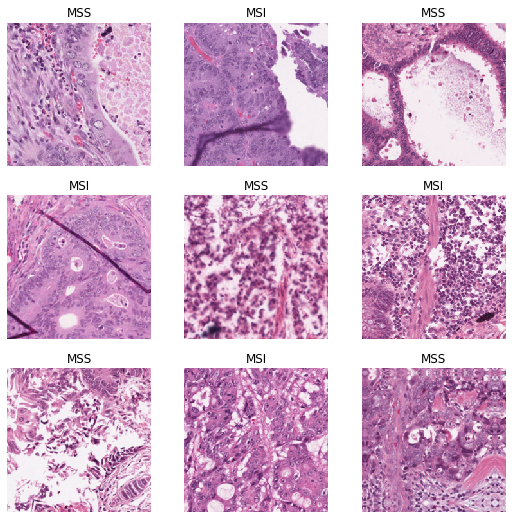

In [105]:
dls.show_batch()

spots_datablock.summary(path)

In [106]:
print (dls[0].tfms)
print (dls[0].after_batch)
bx=dls.one_batch()[0]
print(bx.min(),bx.max(),bx.mean(dim=[0,2,3]),bx.std(dim=[0,2,3]))

[Pipeline: PILBase.create, Pipeline: label_func -> Categorize -- {'vocab': ['MSS', 'MSI'], 'sort': False, 'add_na': False}]
Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Dihedral -- {'size': 224, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.7700]],

         [[0.6154]],

         [[0.7457]]]], device='cuda:0'), 'std': tensor([[[[0.1949]],

         [[0.2642]],

         [[0.1937]]]], device='cuda:0'), 'axes': (0, 2, 3)}
TensorImage(-3.8499, device='cuda:0') TensorImage(1.4557, device='cuda:0') TensorImage([-0.2341, -0.3921, -0.2917], device='cuda:0') TensorImage([0.7682, 0.7371, 0.7279], device='cuda:0')


In [107]:
Path('models').ls()

(#44) [Path('models/segment_tissue_0.4554598927497864_f_acc_0.8807398080825806.pth'),Path('models/segment_tissue_0.3260129690170288_f_acc_0.900049090385437.pth'),Path('models/segment_tissue_presizing0.4628714621067047_f_acc_0.8756903409957886.pth'),Path('models/segment_tissue_presizing0.34281474351882935_f_acc_0.9168598055839539.pth'),Path('models/segment_tissue_9_class_2.2231385707855225_f_acc_nan.pth'),Path('models/segment_tissue_9_class.pth'),Path('models/pretrained_tissue_aug_0.999517653648182.pth'),Path('models/pretrained_tissue_aug_BAC_epicolon0.9993681800971788.pth'),Path('models/MSI_classifier_epicolon_0.8591032422872864.pth'),Path('models/MSI_classifier_epicolon_level_3_0.8562268910196152.pth')...]

In [108]:
b = dls.one_batch()


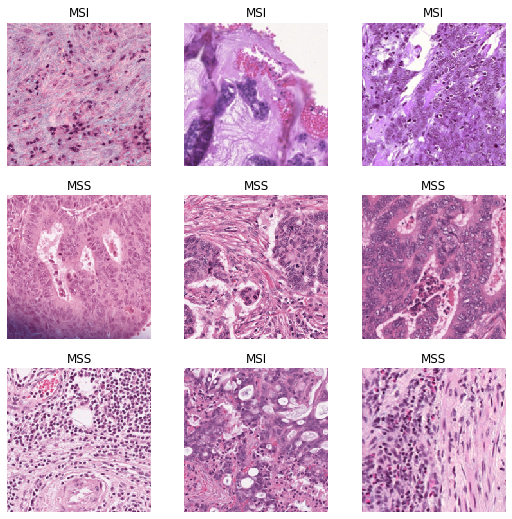

In [109]:

dls.show_batch(b)

In [110]:
learn_pretrained = cnn_learner(dls, resnet34, metrics=[error_rate,RocAuc()],normalize=False, n_out=9,
                                  path=Path("."))

pd.options.mode.chained_assignment = None  # default='warn'
tissue = 'TUM'
cls_tissue = ['ADI', 'BAC', 'DEB', 'LYM', 'MUC', 'MUS', 'NOR', 'STR', 'TUM']


tissue_model = 'pretrained_tissue_aug_BAC_epicolon0.9993681800971788'
learn_pretrained.load(tissue_model)
m_tissue_classifier =  learn_pretrained.model

test_example = True
if test_example: #tissue classification results are not good in TCGA, probably because of magnification and/or color normalization in downloaded tiles 
    #x = torch.randn(2,3,300,300) #two dummy images
    bx = b[0]
    preds = m_tissue_classifier(bx.cpu())
    #print(preds)
    preds = torch.argmax(nn.Softmax(dim=1)(preds), dim = 1)
    #print(preds)
    classes = [cls_tissue[i] for i in preds]
    print(classes[:9])

['MUC', 'MUC', 'TUM', 'NOR', 'STR', 'TUM', 'LYM', 'NOR', 'STR']


In [111]:
class TissueBackbone(Module ):
    def __init__(self, m_tissue_classifier ):
        
        
        self.feature_extractor = nn.Sequential( # feature extractor
            nn.ModuleList(m_tissue_classifier.children())[0], 
            ).cuda()
        
        self.msi_classifier = nn.Sequential(
            AdaptiveConcatPool2d(1),
            Flatten(full=False), 
            #nn.AdaptiveAvgPool2d(1),
            #nn.Flatten(),
            nn.BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(p=0.25, inplace=False),
            nn.Linear(in_features=1024, out_features=512, bias=False),
            nn.ReLU(inplace = True),
            nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(p=0.25, inplace=False),
            nn.Linear(in_features=512, out_features=2, bias=False)).cuda()
        
        
    
    def forward(self, x):
        
        
        
        fe = self.feature_extractor(x)
        pred_msi = self.msi_classifier(fe)
        
        
        return pred_msi


@patch
def _do_one_batch(self:Learner):
    vanilla = True
    features = None
    for child in self.model.children():
        for param in child.parameters():
                param.requires_grad = True
    
    self.pred = self.model(*self.xb);                self('after_pred')
    if len(self.yb) == 0: return
    if not self.training: 
        self.loss = self.loss_func(self.pred, self.yb[0]); self('after_loss')
    else:
        self.loss = self.loss_func(self.pred[0], self.yb[0]); self('after_loss')
    if not self.training: return
    
    self('before_backward')
    self._backward();                                self('after_backward')
    self._step();                                    self('after_step')
    self.opt.zero_grad()
    print(f'finished 1º training step: MSI-Pred {self.loss}')
    
    if vanilla == True: return
    
    for child in self.model.feature_extractor.children():
        for param in child.parameters(): param.requires_grad = False
    #features = self.model.feature_extractor(*self.xb)    
    features = self.model(*self.xb,_forward='feature_extractor')    

    for child in self.model.bias_classifier.children():
        for param in child.parameters(): param.requires_grad = True
    
    #self.pred = self.model.bias_classifier(features);                self('after_pred')
    self.pred = self.model(features,_forward='bias_classifier');                self('after_pred')
    if len(self.yb[1]) == 0: return
    
    #conditioning target: stratify bias-pred by MSI status to avoid untoward learning from MSI status: select only one class (MSI +) as it represents evenly both HGUA and Others samples on this dls  
    cond_target = self.yb[1] #In Hospital target --> 
    cond_target[self.yb[0] == 0] = -100 #ablate MSS samples (coded 0)
    
    self.loss =  self.loss_func(self.pred, cond_target); self('after_loss')
    if not self.training: return
    
    self('before_backward')
    self._backward();                                self('after_backward')
    self._step();                                    self('after_step')
    self.opt.zero_grad()
    print(f'finished 2º training step: Bias-Pred {self.loss}')            
     
        
        
    for child in self.model.feature_extractor.children():
        for param in child.parameters():
                param.requires_grad = True
    for child in self.model.bias_classifier.children():
        for param in child.parameters():
                param.requires_grad = False
    
    self.pred = self.model(*self.xb);                self('after_pred')
    if len(self.yb[1]) == 0: return
    
    #Invert values in Hospital target
    invert_targ = 1 - self.yb[1] 
    invert_targ[self.yb[0] == 0] = -100 ##In Hospital target --> ablate MSS samples (coded 0)
    #-((tanh(2x - 1) + 1) / 2) + 1
    #-(1 / (1 + ℯ^(-(4x - 2)))) + 1
    self.loss = - self.loss_func(self.pred[1], cond_target); self('after_loss')
    if not self.training: return
    
    self('before_backward')
    self._backward();                                self('after_backward')
    self._step();                                    self('after_step')
    self.opt.zero_grad()
    print(f'finished 3º training step: Bias-Distillator {self.loss}')

In [112]:
def accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    
    pred,targ = flatten_check(inp.argmax(dim=axis), targ)
    return (pred == targ).float().mean()

fastai.metrics.accuracy = accuracy

In [113]:
tissue_backbone = True
if tissue_backbone: 
    x = torch.randn(2, 3, 300, 300).cuda()
    m = TissueBackbone(m_tissue_classifier)
    y = m(x)
    print(y)
    test_eq(y[0].shape, [2])
    learn = Learner(dls, m, metrics=[error_rate,RocAucBinary()], loss_func = CrossEntropyLossFlat(),
                    #cbs=[PutYinX(m_tissue_classifier),DropBiasInXY()])# cbs = CutMix(alpha=1.))
                    cbs = [SaveModelCallback(monitor='roc_auc_score')])
                   #)#,  

else: #Vanilla 
    learn = cnn_learner(arch=resnet34, #loss_func = CrossEntropyLossFlat,
                dls = dls, metrics=[error_rate, RocAucBinary()
                                   ], normalize=False, cbs=[PutYinX(m_tissue_classifier)])

tensor([[-0.5075,  0.7882],
        [ 0.8068, -0.8068]], device='cuda:0', grad_fn=<MmBackward>)


In [114]:
learn.show_training_loop()

Start Fit
   - before_fit     : [TrainEvalCallback, Recorder, ProgressCallback, SaveModelCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : []
         - after_pred     : []
         - after_loss     : []
         - before_backward: []
         - after_backward : []
         - after_step     : []
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - after_cancel_validate: [Recorder]
     - after_validate : [Recorder, ProgressCallback]
  End Epo

In [115]:
learn.to_fp16()

In [116]:
train = True

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.019054606556892395)

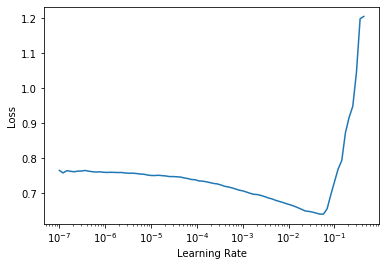

In [117]:
learn.lr_find()

In [119]:
if train:
    learn.fit_one_cycle(5,1e-2,  cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.1, patience=2))

epoch,train_loss,valid_loss,error_rate,roc_auc_score,time
0,0.311530,0.751794,0.263094,0.713580,01:51
1,0.291718,0.781019,0.278411,0.709634,01:52
2,0.247596,1.043077,0.388205,0.635105,01:52


Better model found at epoch 0 with roc_auc_score value: 0.7135804795466255.
No improvement since epoch 0: early stopping


/home/auri/anaconda3/envs/fastaiAP/lib/python3.7/site-packages/fastai/learner.py:54: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [ ]:
if train:
    #learn.fine_tune(20)
    auc_val = learn.final_record[3]
    learn.save(f'MSI_classifier_TissueBackbone_TCGA_level_{zoom_filter}_TUM_{auc_val}' )
else:
    #learn.load(f'MSI_classifier_TissueBackbone_epicolon_cb_level_None_0.8720548604657441')
    learn.load('MSI_classifier_TissueBackbone_epicolon_BiasDistilled_level_None_TUM_0.8762951242193902')

In [ ]:
learn.final_record

In [ ]:
preds, targs, decoded, losses = learn.get_preds(dl=dls[1], with_input=False, with_loss=True, with_decoded=True, act=lambda x: torch.softmax(x.float(),dim=-1))
#preds, targs, decoded, losses = learn.get_preds(dl=new_dl, with_input=False, with_loss=True, with_decoded=True, act=lambda x: torch.softmax(x.float(),dim=-1), reorder = False)


In [ ]:
preds_val = preds.float().softmax(dim=-1).cpu()[...,-1]
print(preds_val.shape)

In [ ]:
decoded, targs, losses, preds

In [ ]:
print(preds.shape, targs.shape, losses.shape)

In [ ]:
np.array(decoded).mean(), np.array(targs).mean(),

In [ ]:
preds = preds[targs >= 0]
losses = losses[targs >= 0]
decoded = decoded[targs >= 0]
targs = targs[targs >= 0]


In [ ]:
t = targs.cpu().numpy() #MSS is labeled as 0, MSI as 1
p = preds.float().softmax(dim=-1).cpu()[...,-1]
fpr, tpr, thresholds = skm.roc_curve(targs.cpu().numpy(),preds.float().softmax(dim=-1).cpu()[...,-1])
fpr, tpr, thresholds = skm.roc_curve(t,p)
#get the best threshold
j = tpr - fpr
ix = np.argmax(j)
best_thresh = thresholds[ix]
auc = skm.auc(fpr, tpr)
print(f'auc = {auc}, best threshold = {best_thresh}')
import matplotlib.pyplot as plt  # doctest: +SKIP
import numpy as np
from sklearn import metrics
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='MMR estimator')
display.plot() 
plt.scatter(fpr[ix], tpr[ix], marker = 'o', color = 'black', label = 'Best')
plt.show() 

In [ ]:
precision, recall, thresholds = metrics.precision_recall_curve(t,p)

In [ ]:
precision_recall_threshold = np.array(list(zip(precision, recall, thresholds)))
precision_recall_threshold[precision_recall_threshold[:,2] == 0.5]

In [ ]:
import seaborn as sns

df = pd.DataFrame(data=np.c_[preds, targs, losses, decoded],
                    columns=['preds_0', 'preds_1','target', 'loss', 'decoded'])
df_normal = df.loc[df.target == 0, 'preds_0']
df_MMR = df.loc[df.target == 1, 'preds_1']
df_MMR = 1 - df_MMR

sns.distplot(df_normal, hist=True,  color = "g")
sns.distplot(df_MMR, hist=True, color = "r")

In [ ]:
targs.cpu().numpy(), preds.float().softmax(dim=-1).cpu()

In [ ]:
#confusion matrix whose i-th row and j-th column entry indicates the number of samples with true label being i-th class and predicted label being j-th class.
#[[TN,FP],[FN,TP]]
skm.confusion_matrix(targs.cpu().numpy(), decoded.cpu())

In [ ]:
best_decoded = preds.float().softmax(dim=-1).cpu()[:,1] > best_thresh
best_decoded

In [ ]:
skm.confusion_matrix(targs.cpu().numpy(), best_decoded)

### Agregate prediction by patient

In [ ]:
cx[['MSIStatus', 'submitter_id']]

In [ ]:
files_df = pd.DataFrame()
files_df['path'] = files

In [ ]:
files_df['valid'] = 0
files_df.loc[files_df['path'].str.contains('_VAL'), ['valid' ] = 1